# Handwritten Digits


In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
transform = transforms.Compose([
        # converts the image into numbers, that are understandable by the system. 
        # It separates the image into three color channels 
        # (separate images): red, green & blue. Then it converts the 
        # pixels of each image to the brightness of their color between 0 and 255. 
        # These values are then scaled down to a range between 0 and 1. 
        # The image is now a Torch Tensor.
        transforms.ToTensor(),
        # normalizes the tensor with a mean and standard deviation 
        # which goes as the two parameters respectively.
        transforms.Normalize((0.5,), (0.5,)),
    ])

In [3]:
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

64 images in each batch and each image has a dimension of 28 x 28 pixels

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


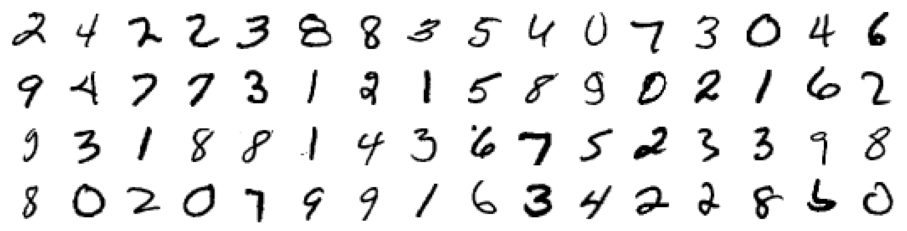

In [9]:
plt.figure(figsize=(16,4))

for i, image in enumerate(images, start=1):
    plt.subplot(4, 16, i)
    plt.axis('off')
    plt.imshow(image.numpy().squeeze(), cmap='gray_r')

plt.show()

## Setup Neural Network

![NN](images/handwritten_digits_nn.png)

 - There are three linear layers with ReLU activation ( a simple function which allows positive values to pass through, whereas negative values are modified to zero )
 - The output layer is a linear layer with LogSoftmax activation because this is a classification problem.
 - [torch.nn Library](https://pytorch.org/docs/stable/nn.html)
 - [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax)
   $ LogSoftmax(x_i) = \log(\dfrac{exp(x_i)}{\sum_{j} exp(x_j)}) $

In [10]:
# 784 inputs (28 x 28)
input_size = 784

hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [11]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


In [12]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0041,  0.0041,  0.0041,  ...,  0.0041,  0.0041,  0.0041],
        [-0.0069, -0.0069, -0.0069,  ..., -0.0069, -0.0069, -0.0069],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003]])


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6596354115238068
Epoch 1 - Training loss: 0.28694582887009773
Epoch 2 - Training loss: 0.22455471886325873
Epoch 3 - Training loss: 0.17984287210031233
Epoch 4 - Training loss: 0.15092963642125
Epoch 5 - Training loss: 0.1283605849908502
Epoch 6 - Training loss: 0.11134588557368974
Epoch 7 - Training loss: 0.09879818272643856
Epoch 8 - Training loss: 0.0886722608466448
Epoch 9 - Training loss: 0.08084256248498983
Epoch 10 - Training loss: 0.07257076976910186
Epoch 11 - Training loss: 0.06611849164574353
Epoch 12 - Training loss: 0.06070632859419134
Epoch 13 - Training loss: 0.05611919339357524
Epoch 14 - Training loss: 0.05275082191738334

Training Time (in minutes) = 2.045383886496226


In [15]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 5


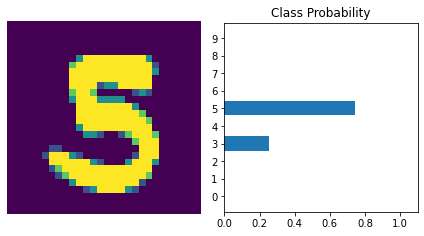

In [17]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [18]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9782


In [19]:
torch.save(model, './models/handwritten_digits.pt') 